<a href="https://colab.research.google.com/github/jhkr1/DaySchool-Vehicle-InsuranceFraud-Detection-Hackathon/blob/main/%EB%8D%B0%EC%9D%B4%EC%8A%A4%EC%BF%A8_%EA%B8%B0%EC%B4%88_%ED%8A%B8%EB%9E%992025_%EC%9E%90%EB%8F%99%EC%B0%A8_%EB%B3%B4%ED%97%98%EC%82%AC%EA%B8%B0_%ED%83%90%EC%A7%80_%ED%95%B4%EC%BB%A4%ED%86%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12598 entries, 0 to 12597
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       12598 non-null  object 
 1   age_of_driver            12598 non-null  int64  
 2   gender                   12598 non-null  object 
 3   marital_status           12598 non-null  object 
 4   safty_rating             12598 non-null  int64  
 5   annual_income            12598 non-null  float64
 6   high_education_ind       12598 non-null  int64  
 7   address_change_ind       12598 non-null  object 
 8   living_status            12598 non-null  object 
 9   claim_day_of_week        12598 non-null  object 
 10  accident_site            12598 non-null  object 
 11  past_num_of_claims       12598 non-null  int64  
 12  witness_present_ind      12598 non-null  object 
 13  liab_prct                12598 non-null  int64  
 14  channel               

In [30]:
train['month'].unique()

month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
train['month'] = train['month'].map(month_mapping)
test['month'] = test['month'].map(month_mapping)

In [31]:
train['month'].unique()

array([ 7,  1,  6,  5,  3,  9,  8, 10,  4, 12,  2, 11])

In [33]:
# day 컬럼을 제거한 이유 -> 모델의 성능을 높이기 위해서 제거

train.drop(['ID', 'day'], axis=1, inplace=True)
test.drop(['ID', 'day'], axis=1, inplace=True)

In [70]:
# ID : 고유ID
# age_of driver : 운전자 나이
# gender : 운전자 성별
# marital_status : 결혼 상태
# safty_rating : 운전자의 안전점수
# annual_income : 연간소득(단위:달러)
# high_education_ind : 운전자의 학력
# address_change_ind : 운전자의 주소변경 여부
# living_status : 자동차 소유상태
# claim_day_of_week : 청구된 접수된 요일
# accident_site  : 사고 발생 지역
# past_num_of claims : 과거 청구 건수
# witness_present_ind : 목격자 여부
# liab_prct : 운전자 과실 비율(%)
# channel : 청구 접수 매체
# policy_report_filed_ind : 경찰 신고 접수 여부
# claim_est_payout : 보험금 지급 추정 비율(%)
# age_of_vehicle : 자동차 연식
# vehicle_category : 자동차 카테고리
# vehicle_price : 자동차 가격(단위:달러)
# vehicle_color : 자동차 색깔
# vehicle_weight : 자동차 무게(kg)
# fraud : 사기여부
# year : 청구(년)
# month : 청구(월)
# day : 청구(일)

# 결측치 존재 컬럼 -> claim_est_payout, age_of_vehicle


# 이렇게 분류할 경우 문제 발생 -> fraud 같은 Int 타입의 범주형 변수들이 연속형 변수에 끼게 됨
# continuous_columns = train.select_dtypes(['int', 'float']).columns.tolist()
# categoriecal_columns = train.select_dtypes('object').columns.tolist()

continuous_columns = train.select_dtypes(['int', 'float']).columns.tolist()
categoriecal_columns = train.select_dtypes('object').columns.tolist()

categorical_in_numeric = [col for col in continuous_columns if train[col].nunique() < 5]
# 월 컬럼 추가
categorical_in_numeric.append('month')
# print(categorical_in_numeric)

continuous_columns = [col for col in continuous_columns if col not in categorical_in_numeric]
categoriecal_columns.extend(categorical_in_numeric)
if 'fraud' in categoriecal_columns:
    categoriecal_columns.remove('fraud')
# continuous_columns
categoriecal_columns

['gender',
 'marital_status',
 'address_change_ind',
 'living_status',
 'claim_day_of_week',
 'accident_site',
 'witness_present_ind',
 'channel',
 'vehicle_category',
 'vehicle_color',
 'high_education_ind',
 'past_num_of_claims',
 'policy_report_filed_ind',
 'year',
 'month']

In [71]:
def plot_pie_charts(df, target_cols, threshold=12):
  if isinstance(target_cols, str):
    cols_to_plot = [target_cols]
  else:
    cols_to_plot = target_cols

  for col in cols_to_plot:
    if col not in df.columns:
      print(f"경고: '{col}'이 데이터 프레임 내 존재하지 않습니다.")
      continue

    if df[col].nunique() > threshold:
      print(f"{col}의 고유 범수의 개수가 {df[col].nunique()}개 입니다. 이는 시각화가 어려울 수 있습니다.")
    else:
      categories = df[col].value_counts().index
      values = df[col].value_counts().values

      plt.figure(figsize=(10, 7))
      pie_chart = plt.pie(values, labels=categories, autopct='%.1f%%', shadow=True, startangle=90,
                          explode=[0.02] * len(categories))
      plt.title(f'{col} Distribution', fontsize=15)
      plt.axis('equal')
      plt.show()


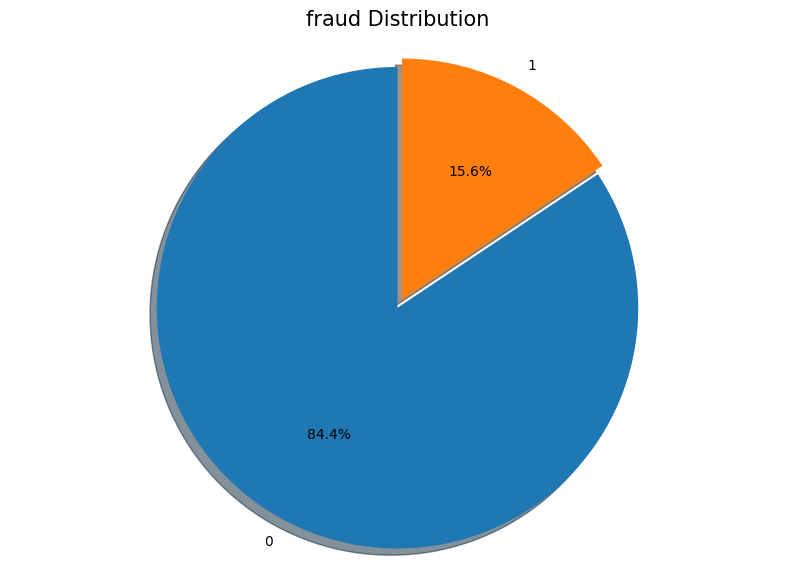

In [39]:
# 0 84,4% 1 15.% -> 사기를 친 사람이 15.6%
plot_pie_charts(train, 'fraud')

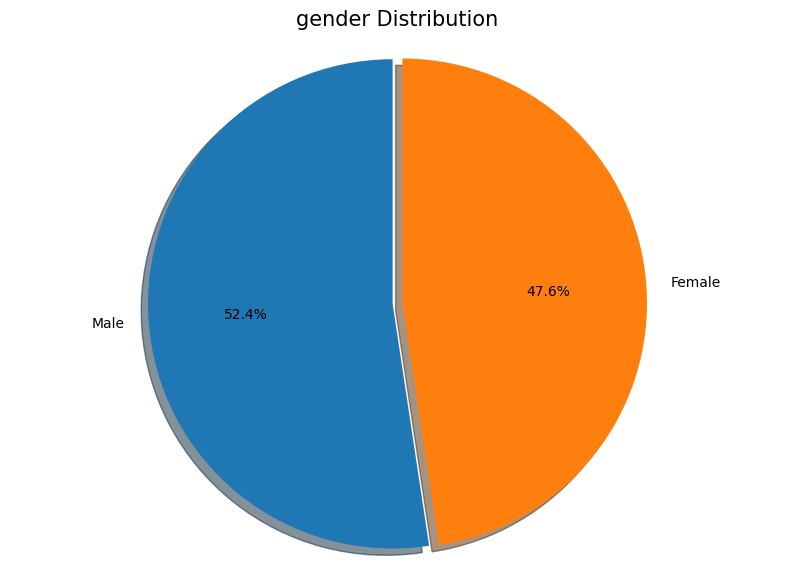

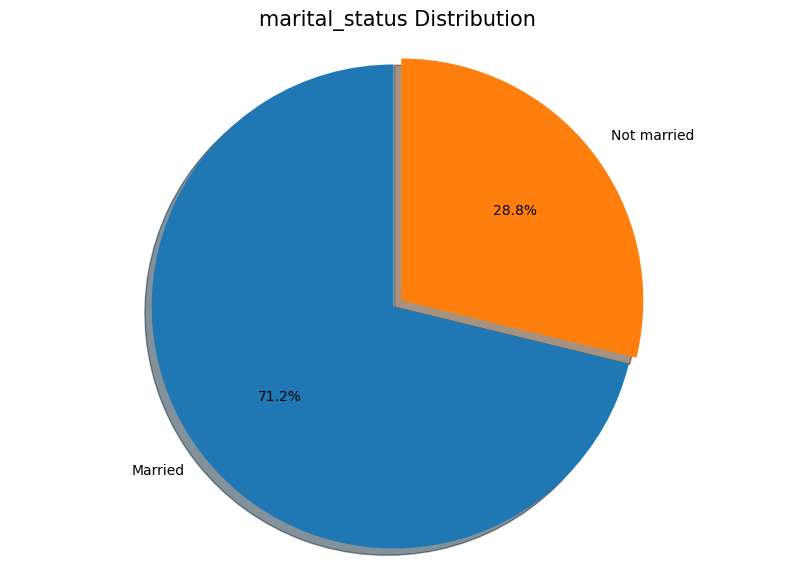

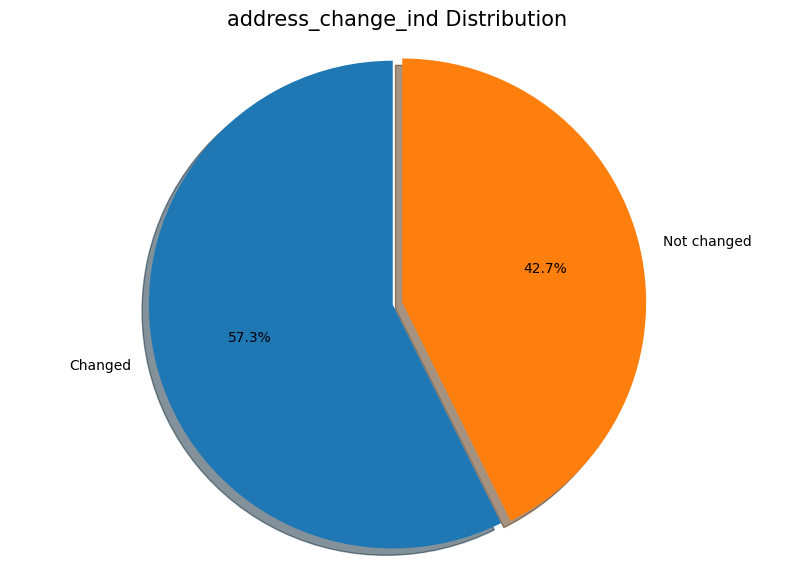

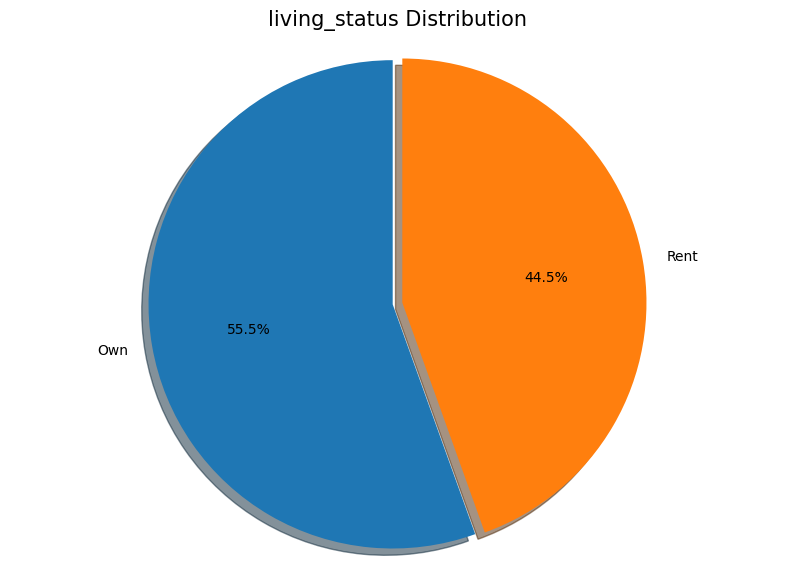

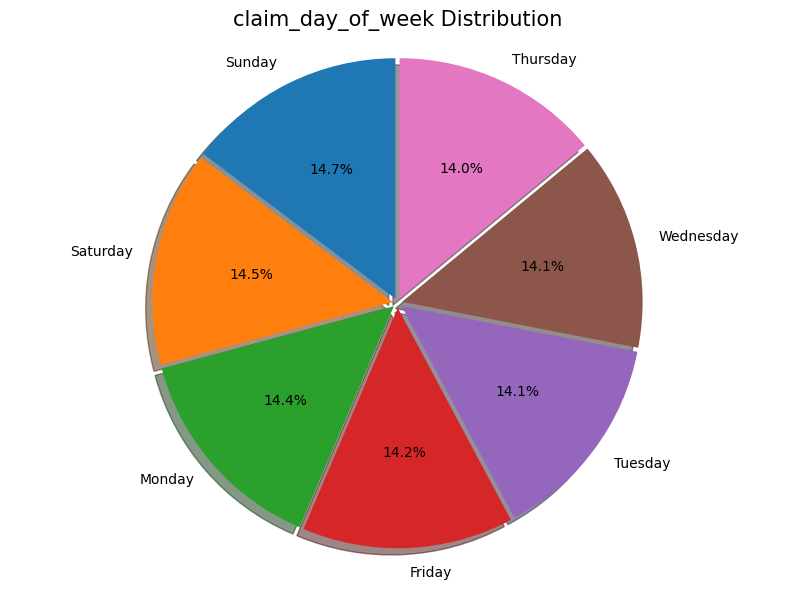

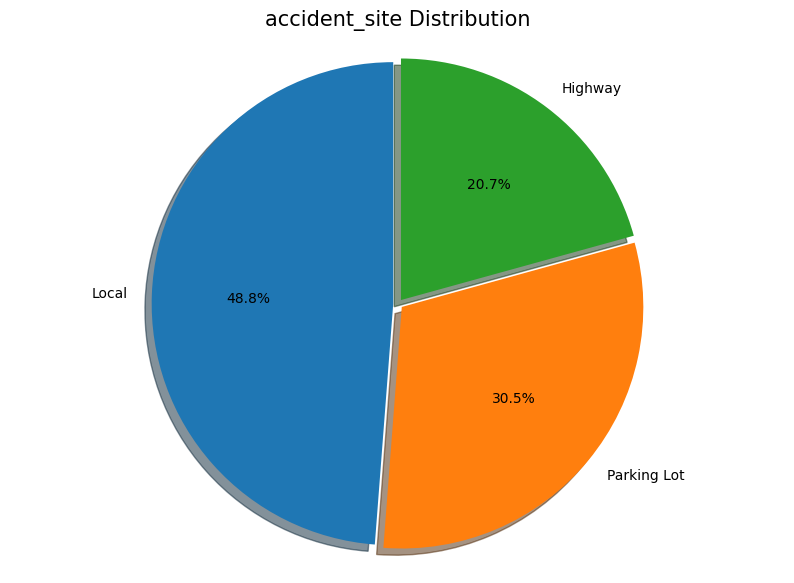

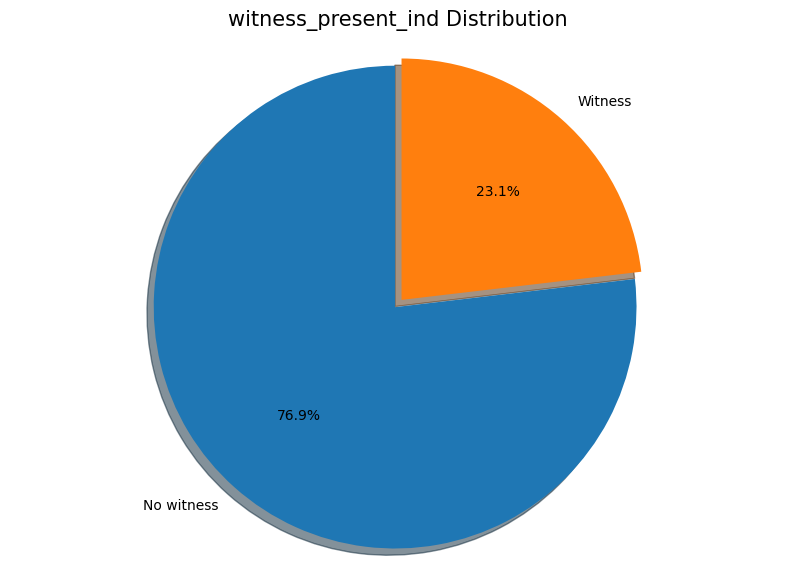

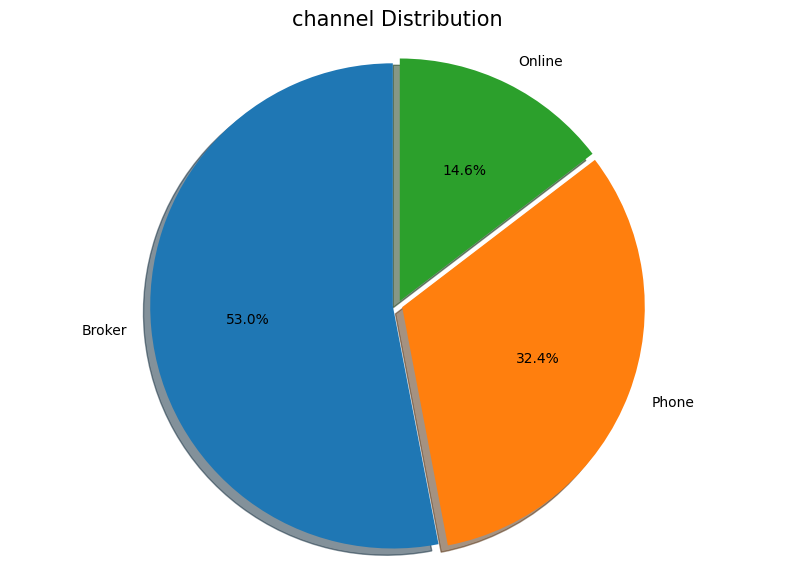

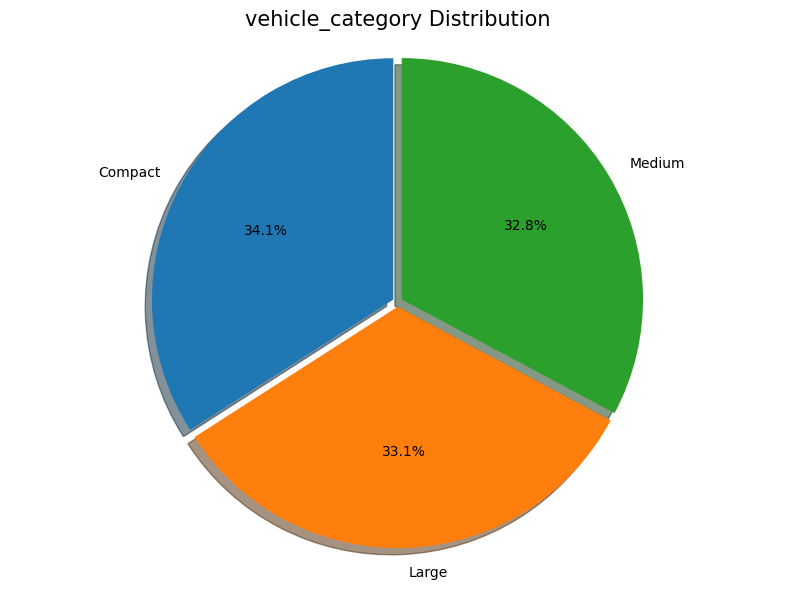

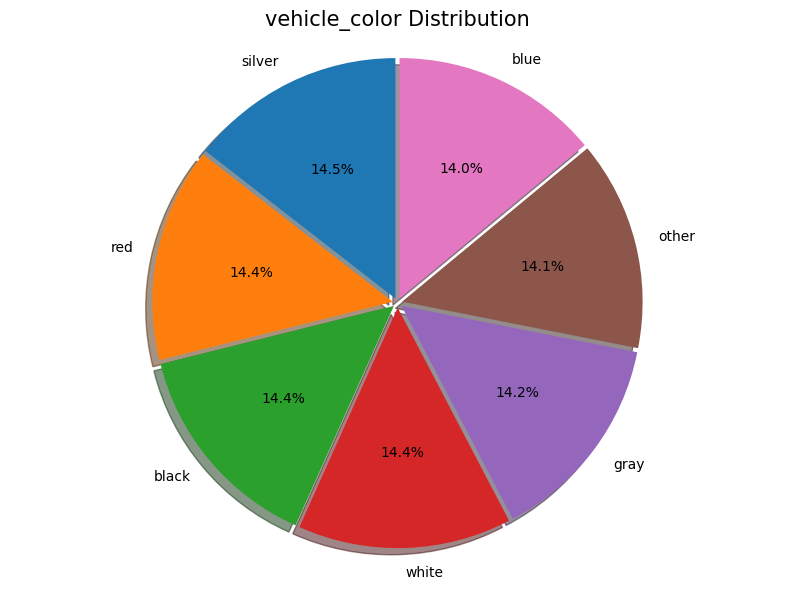

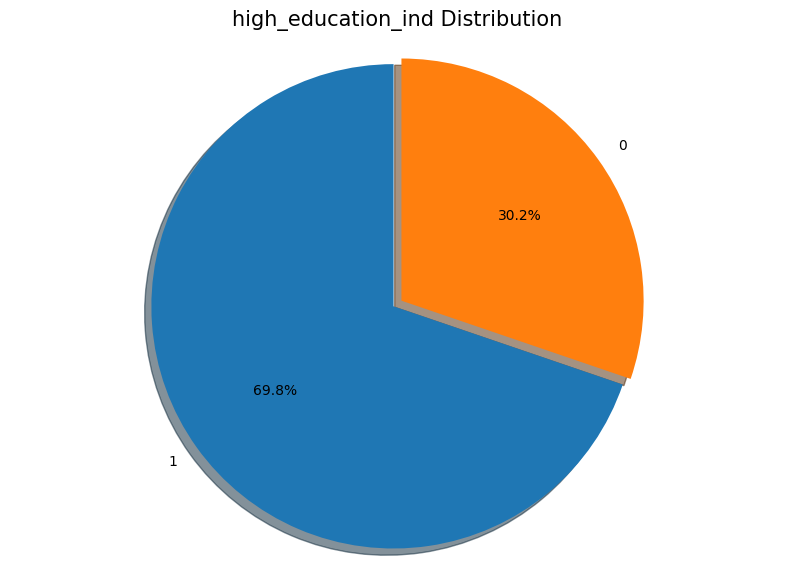

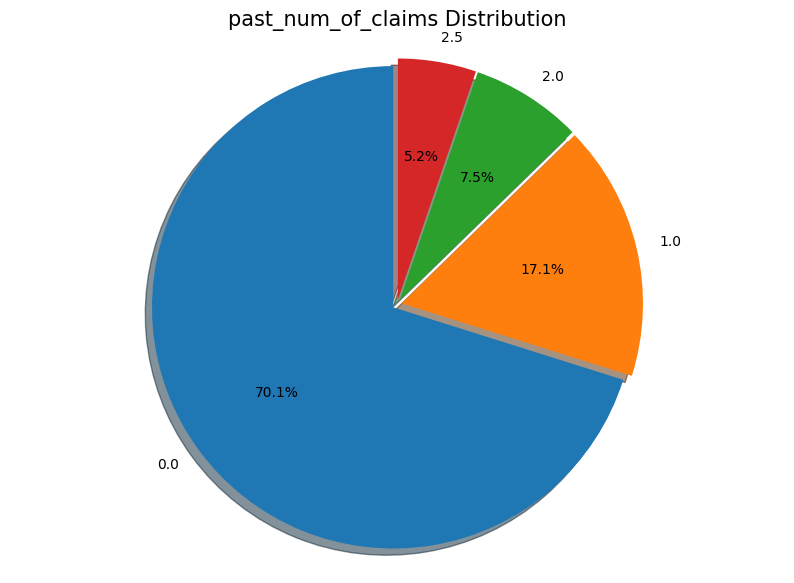

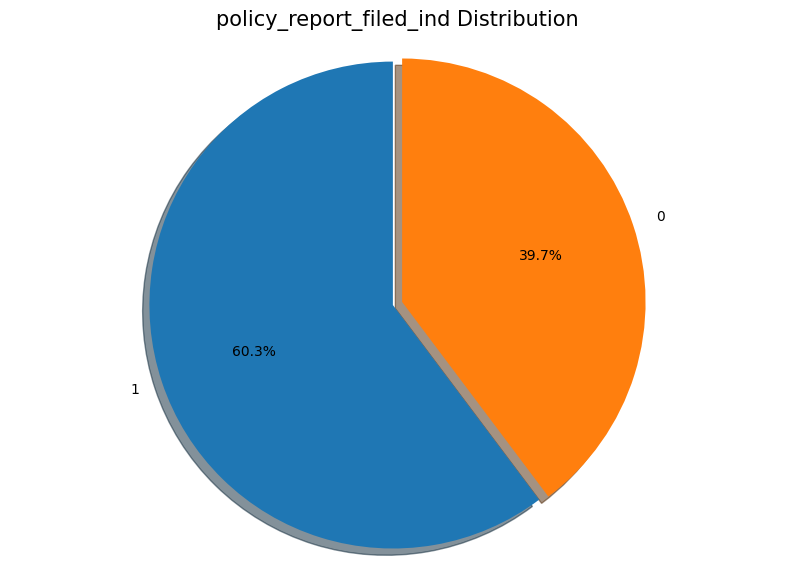

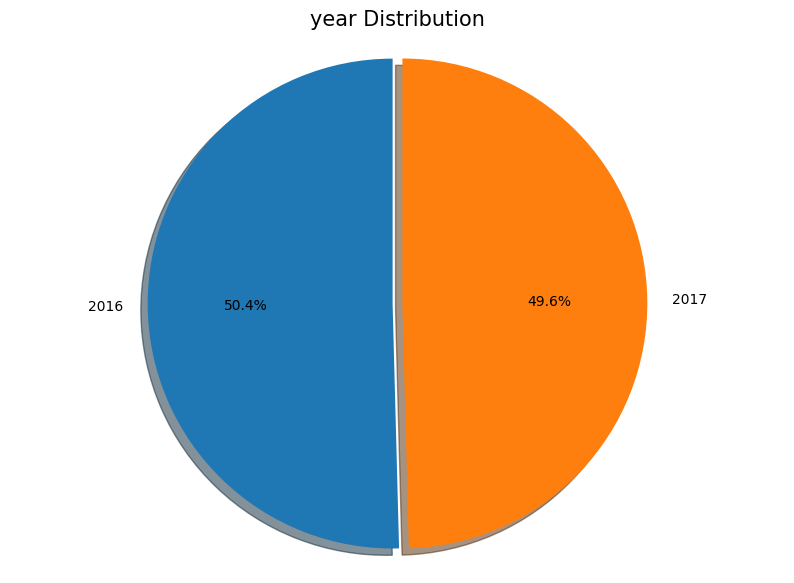

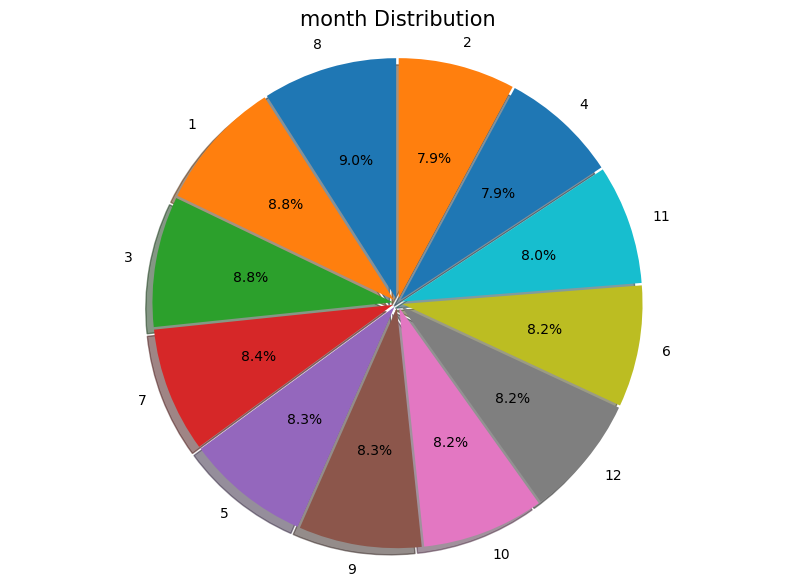

In [72]:
# 범주형 변수의 분포 확인
plot_pie_charts(train, categoriecal_columns)

In [43]:
print(train.groupby('vehicle_color')['fraud'].mean().sort_values(ascending=False))  # 자동차 색깔별 대한 사기율
print(train.groupby('month')['fraud'].mean().sort_values(ascending=False)) # 월별 사기율

vehicle_color
black     0.162534
red       0.160882
blue      0.159387
silver    0.158356
gray      0.153374
white     0.151381
other     0.149128
Name: fraud, dtype: float64
month
8     0.176471
10    0.168279
4     0.162462
11    0.162055
5     0.160000
6     0.159223
1     0.154815
12    0.154070
7     0.151887
2     0.144299
9     0.142171
3     0.140921
Name: fraud, dtype: float64


In [44]:
# 이상치 계산하는 함수
def calculate_outliers_IQR(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lb = Q1 - 1.5 * IQR
  ub = Q3 + 1.5 * IQR

  return lb, ub

In [45]:
# IQR+히스토그램을 이용한 이상치 탐지함수
def plot_histograms_with_iqr(df, feature_columns, nrows=4, ncols=4, figsize=(14, 14)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(feature_columns):
        lower_bound, upper_bound = calculate_outliers_IQR(df, col)
        sns.histplot(x=col, data=df, ax=axes[i], kde=True)
        axes[i].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
        axes[i].axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend()
    # 사용하지 않은 subplot 삭제
    for j in range(len(feature_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Distribution of Features with IQR Bounds')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

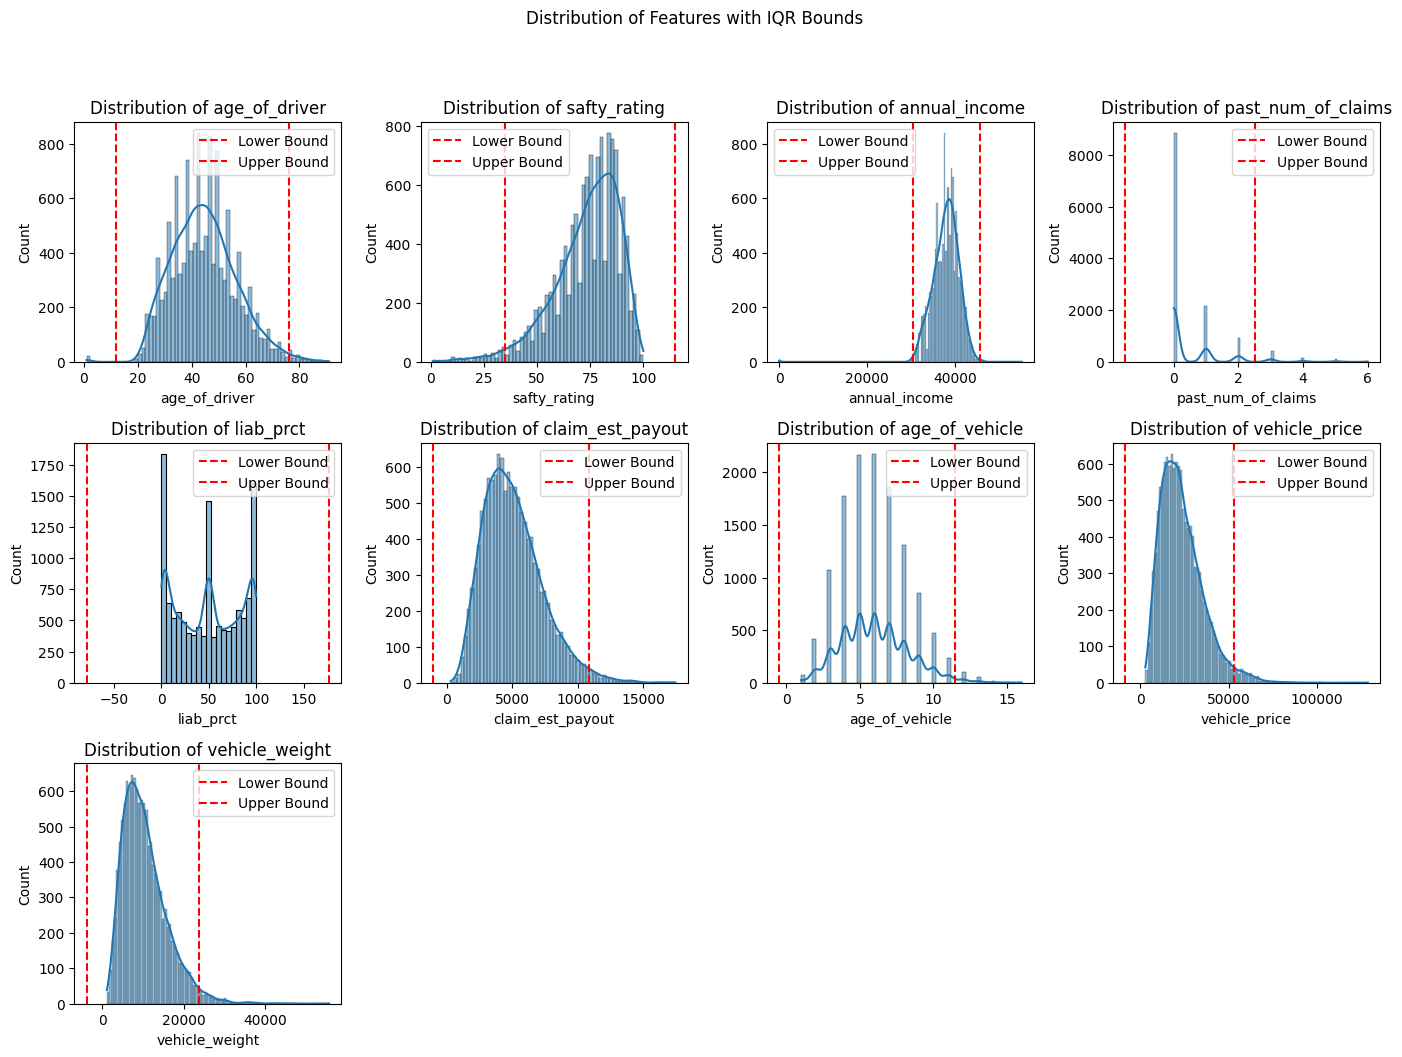

In [46]:
plot_histograms_with_iqr(train, continuous_columns)

In [47]:
# Unknown 값 존재
train['witness_present_ind'].unique()
train['marital_status'].unique()

array(['Married', 'Not married', 'Unknown'], dtype=object)

In [48]:
# Unknown 값을 최빈값으로 대체
train.loc[train['witness_present_ind'] == 'Unknown', 'witness_present_ind'] = train['witness_present_ind'].mode()[0]
train.loc[train['marital_status'] == 'Unknown', 'marital_status'] = train['marital_status'].mode()[0]

test.loc[test['witness_present_ind'] == 'Unknown', 'witness_present_ind'] = test['witness_present_ind'].mode()[0]
test.loc[test['marital_status'] == 'Unknown', 'marital_status'] = test['marital_status'].mode()[0]

In [50]:
train['witness_present_ind'].unique()
train['marital_status'].unique()

array(['No witness', 'Witness'], dtype=object)

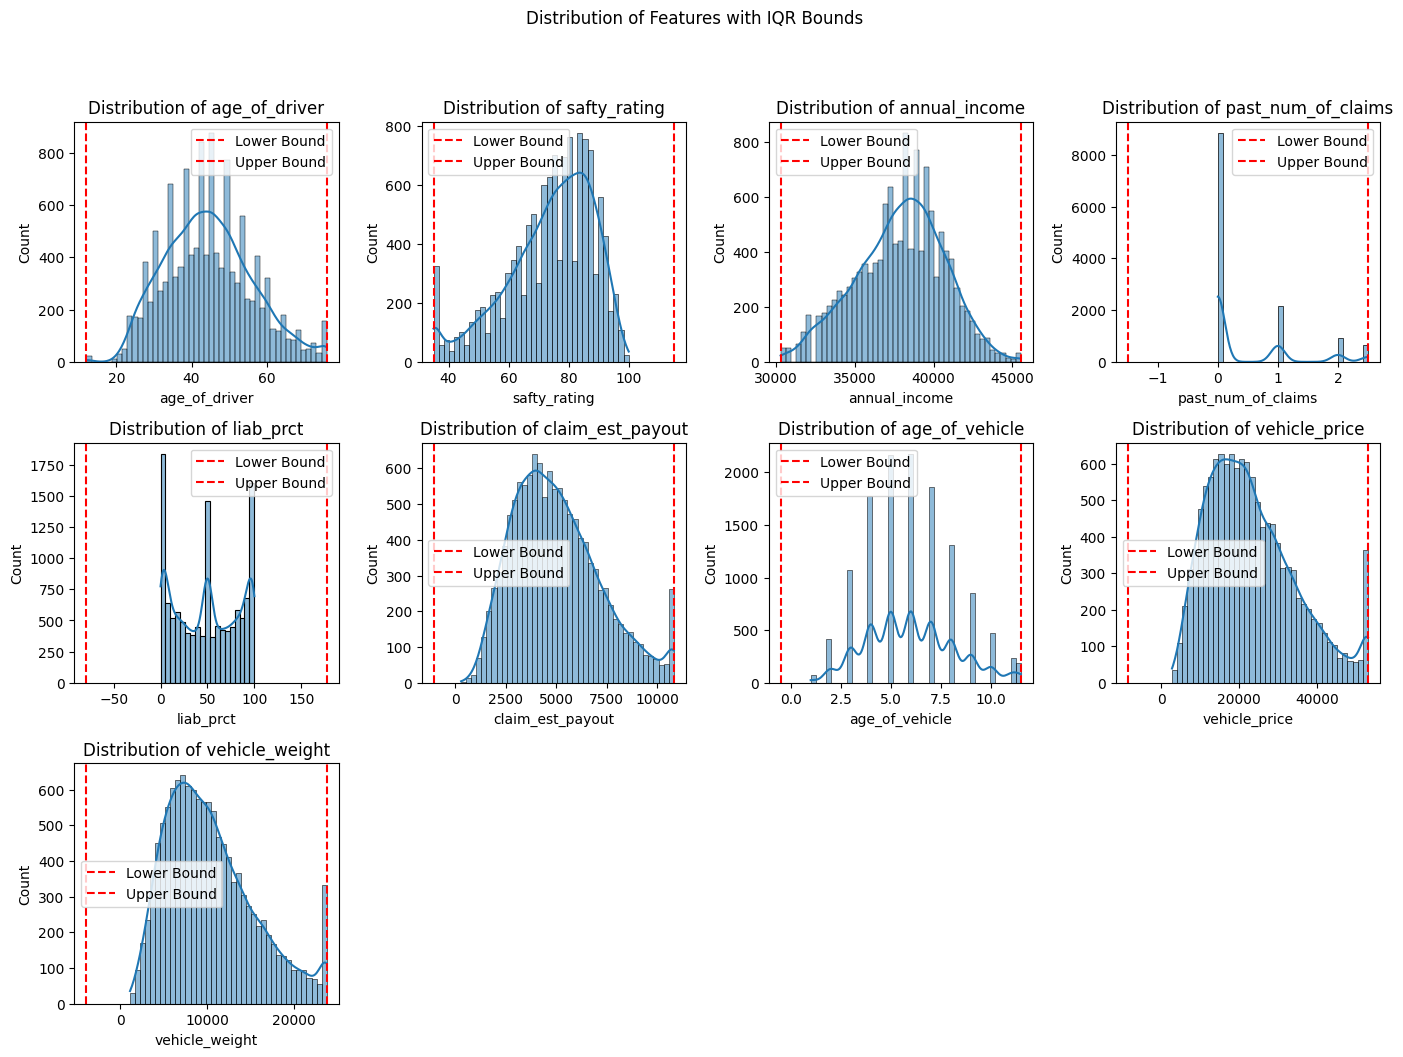

In [51]:
# 연속형 변수의 이상치를 경계값으로 대체
def outlier_replace(df, col, lower_bound, upper_bound):
    if df[col].dtype != 'float64':
      df[col] = df[col].astype('float64')
    df.loc[(df[col] < lower_bound), col] = lower_bound
    df.loc[(df[col] > upper_bound), col] = upper_bound

    return df


for col in continuous_columns:
    lower_bound, upper_bound = calculate_outliers_IQR(train, col)
    train_replace = outlier_replace(train, col, lower_bound, upper_bound)
    test_replace = outlier_replace(test, col, lower_bound, upper_bound)

plot_histograms_with_iqr(train_replace, continuous_columns)


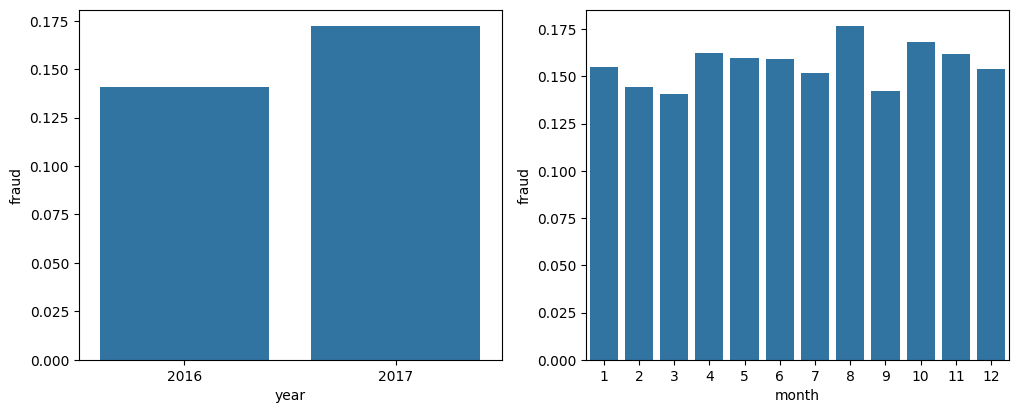

In [52]:
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='fraud',data=train.groupby('year')['fraud'].mean().reset_index())

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='fraud',data=train.groupby('month')['fraud'].mean().reset_index())

In [54]:
train['claim_est_payout'].isna().sum() # 12개의 결측치 존재
train['age_of_vehicle'].isna().sum() # 6개의 결측치 존재

print(f"train 처리 전 데이터 개수: {len(train_replace)}")
print(f"train 처리 전 결측치 개수: {train_replace.isnull().sum().sum()}") # 전체 결측치 개수 확인
print("-" * 50)

# 최빈값으로 결측치 채우기
train_cleaned = train.fillna(train.mode().iloc[0])

print(f"train 처리 후 데이터 개수: {len(train_cleaned)}")
print(f"train 처리 후 결측치 개수: {train_cleaned.isnull().sum().sum()}")
print("-" * 50)

print(f"test 처리 전 데이터 개수: {len(test_replace)}")
print(f"test 처리 전 결측치 개수: {test_replace.isnull().sum().sum()}")
print("-" * 50)

test_cleaned = test.fillna(train.mode().iloc[0])

print(f"test 처리 후 데이터 개수: {len(test_cleaned)}")
print(f"test 처리 후 결측치 개수: {test_cleaned.isnull().sum().sum()}")

train 처리 전 데이터 개수: 12598
train 처리 전 결측치 개수: 18
--------------------------------------------------
train 처리 후 데이터 개수: 12598
train 처리 후 결측치 개수: 0
--------------------------------------------------
test 처리 전 데이터 개수: 5400
test 처리 전 결측치 개수: 7
--------------------------------------------------
test 처리 후 데이터 개수: 5400
test 처리 후 결측치 개수: 0


In [76]:
# 연속형 변수의 표준화
sc = StandardScaler()
scaled_train_continuous = sc.fit_transform(train_cleaned[continuous_columns])
scaled_test_continuous = sc.transform(test_cleaned[continuous_columns])

# 범주형 변수의 원핫인코딩
ohe = OneHotEncoder(sparse_output=False)
ohe_train_categorical = ohe.fit_transform(train_cleaned[categoriecal_columns])
ohe_test_categorical = ohe.transform(test_cleaned[categoriecal_columns])

# train 병합
scaled_train_continuous = pd.DataFrame(scaled_train_continuous, columns=continuous_columns)
ohe_train_categorical = pd.DataFrame(ohe_train_categorical, columns=ohe.get_feature_names_out(categoriecal_columns))

# test 병합
scaled_test_continuous = pd.DataFrame(scaled_test_continuous, columns=continuous_columns)
ohe_test_categorical = pd.DataFrame(ohe_test_categorical, columns=ohe.get_feature_names_out(categoriecal_columns))


In [77]:
# 피처와 타깃 나누기
y_train = train_cleaned['fraud']
X_train = pd.concat([scaled_train_continuous, ohe_train_categorical], axis=1)
X_test = pd.concat([scaled_test_continuous, ohe_test_categorical], axis=1)

In [86]:
# X, y 정의
X = pd.concat([scaled_train_continuous, ohe_train_categorical], axis=1)
y = train_cleaned['fraud']

# train/validation 분리
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)

print('SMOTE 후 클래스 분포')
print(pd.Series(y_resampled).value_counts(normalize=True))


SMOTE 후 클래스 분포
fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


In [87]:
# 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# 예측
y_pred = rf_model.predict(X_valid_split)
print("Validation F1 Score:", f1_score(y_valid_split, y_pred))

Validation F1 Score: 0.05188679245283019


In [88]:
# 최종 예측 & 제출 파일 생성
rf_model.fit(X, y)
y_pred_test = rf_model.predict(X_test)

submission = pd.read_csv('sample_submission.csv')
submission['fraud'] = y_pred_test
submission.to_csv('submission.csv', index=False)